<h3>Updated on 25/04/2021</h3>

In [1]:
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plotter
import numpy as np
from IPython.display import display, Math, Latex, Image
%matplotlib inline

Here alice_epr and bob_epr are a random array of 0 and 1
<br>0 means that pair should be made |psi+> and 1 means |pis->
<br>Number of pairs of qubits are taken as to be 4 

In [2]:
num_pair = 4
alice_epr = np.random.randint(2, size = num_pair)
bob_epr = np.random.randint(2, size = num_pair)

alice_qubits = QuantumRegister(2*num_pair, 'alice')
bob_qubits = QuantumRegister(2*num_pair, 'bob')
charlie = ClassicalRegister(4*num_pair, 'charlie')

print("alice epr " + str(alice_epr))
print("bob epr " + str(bob_epr))

alice epr [0 1 1 1]
bob epr [0 0 1 0]


Here this is the function to encode qubit indexed a and b of circuit in psi_plus or psi_minus respectively

In [3]:
def encode_psi_plus(circuit, a, b):
    circuit.h(a)
    circuit.x(b)
    circuit.cx(a, b)
    return circuit

def encode_psi_minus(circuit, a, b):
    circuit.x([a,b])
    circuit.h(a)
    circuit.cx(a, b)
    return circuit

In [4]:
circuit = QuantumCircuit(alice_qubits, bob_qubits, charlie)

for i in range(0, 2*num_pair, 2): 
    j = i//2
    #print(j)
    if alice_epr[j] == 0:
        circuit = encode_psi_plus(circuit, alice_qubits[i], alice_qubits[i+1])
    elif alice_epr[j] == 1:
        circuit = encode_psi_minus(circuit, alice_qubits[i], alice_qubits[i+1])
        
    if bob_epr[j] == 0:
        circuit = encode_psi_plus(circuit, bob_qubits[i], bob_qubits[i+1])
    elif bob_epr[j] == 1:
        circuit = encode_psi_minus(circuit, bob_qubits[i], bob_qubits[i+1])
    
circuit.barrier()

<h5>Measurement done in Bell Basis by Charlie</h5>

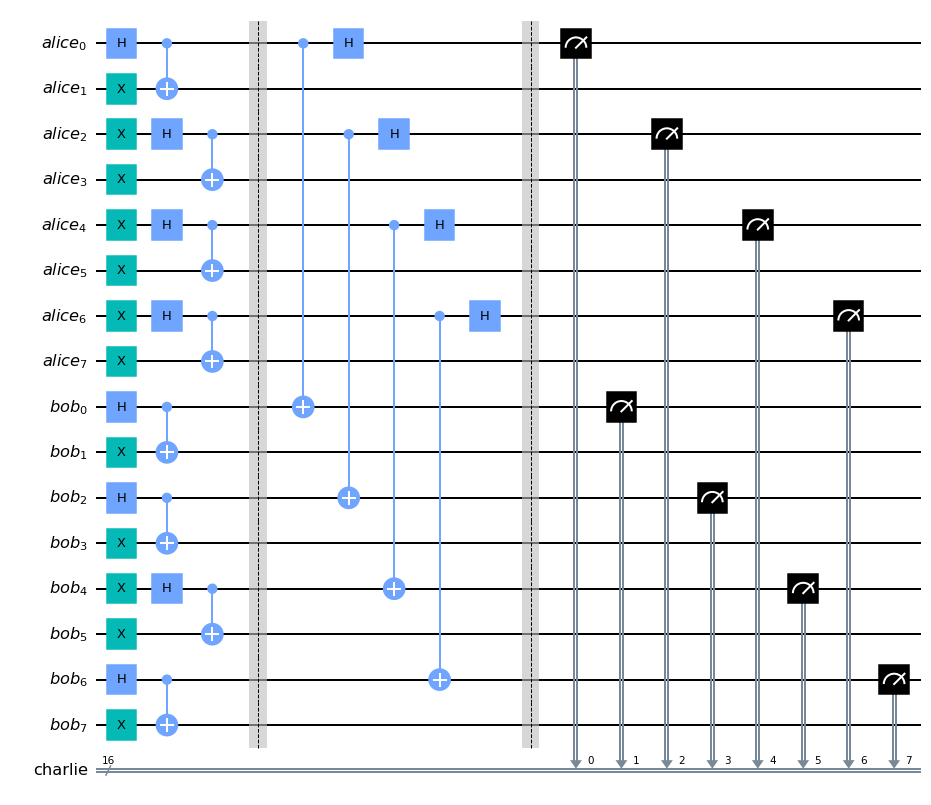

In [5]:
for i in range(0, 2*num_pair, 2):
    j = i//2
    circuit.cx(alice_qubits[i], bob_qubits[i])
    circuit.h(alice_qubits[i])
circuit.barrier()

for i in range(0, 2*num_pair, 2):
    circuit.measure([alice_qubits[i], bob_qubits[i]], [i, i+1])
circuit.draw(output = 'mpl')

In [6]:
def run_circuit(qc2):
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    result = execute(qc2, backend, shots = 2000).result() # we run the simulation
    counts = result.get_counts() # we get the counts
    return counts

def one_shot_result(qc):
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    result = execute(qc, backend, shots = 1).result() # we run the simulation
    counts = result.get_counts() # we get the counts
    return counts

This down below is the preliminary result which could be used for checking the security of the channel

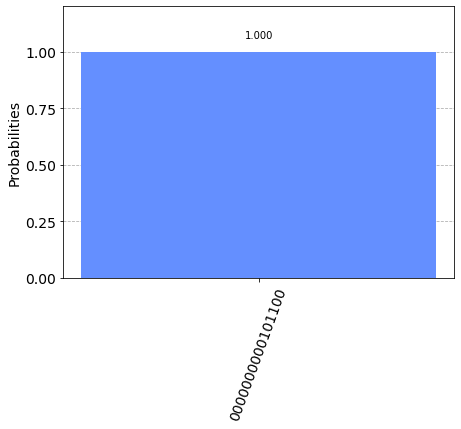

In [7]:
counts = one_shot_result(circuit)
plot_histogram(counts)

In [8]:
r = counts.items()
for res, shots in r:
    result = str(res)
print(result)

0000000000101100


<h4>Message Encoding Step</h4>
<br>Now first generating a randomn message string
<br>bit length will be 2 for each qubit

In [9]:
message = np.random.randint(2, size = 2*num_pair)
print("The initial message is : " + str(message))

The initial message is : [1 0 0 0 1 0 1 0]


Convert all the Alice qubits into psi_minus by using sigma_z operation
<br>
The superdense coding part is accoriding to the given step
![title](Images/img2.png)
With first coulumn as message and second as the unitary gate by Alice

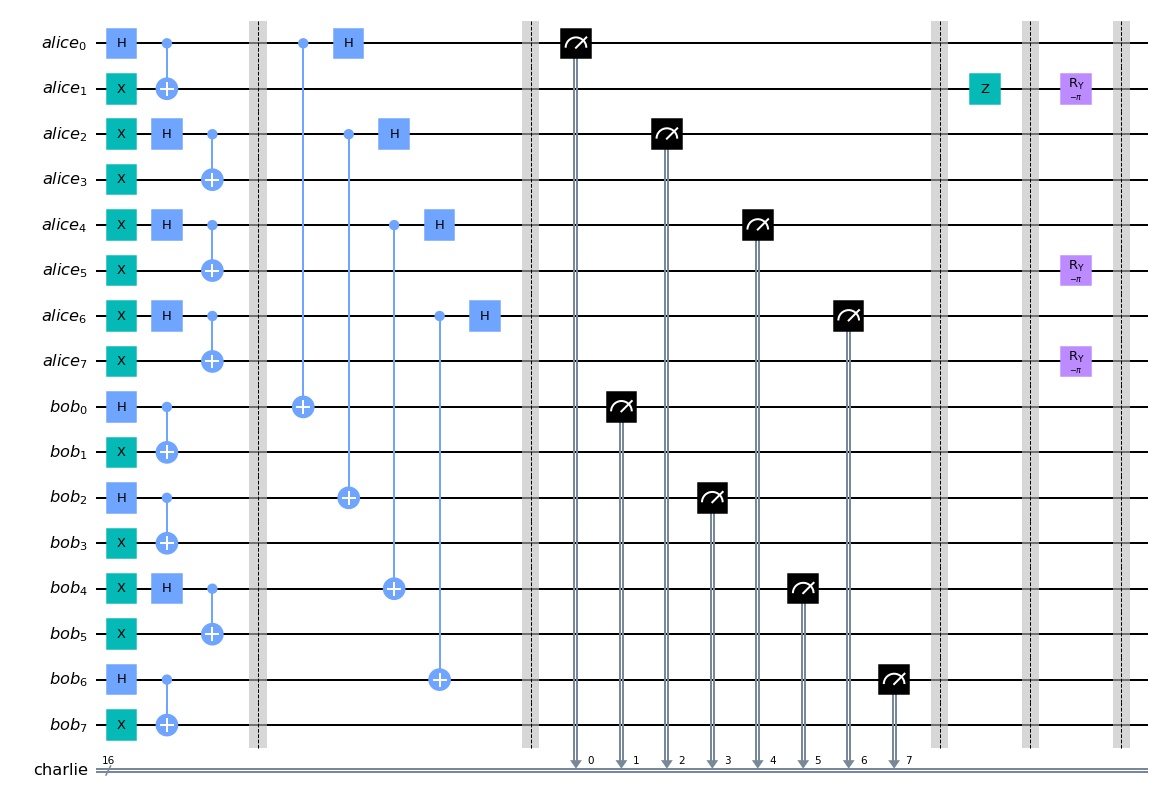

In [10]:
circuit.barrier()
for i in range(1, 2*num_pair, 2):
    if alice_epr[i//2] == 0:
        circuit.z(alice_qubits[i])
circuit.barrier()

for i in range(0, 2*num_pair, 2):
    j = i//2
    if message[i] == 0 and message[i+1] == 0:
        continue
    elif message[i] == 0 and message[i+1] == 1:
        circuit.x(alice_qubits[i+1])
    elif message[i] == 1 and message[i+1] == 0:
        circuit.ry(-np.pi, alice_qubits[i+1])
    elif message[i] == 1 and message[i+1] == 1:
        circuit.z(alice_qubits[i+1])

circuit.barrier()
circuit.draw(output = 'mpl')

Now the Measurement part has to be done by Charlie in Bell Basis 

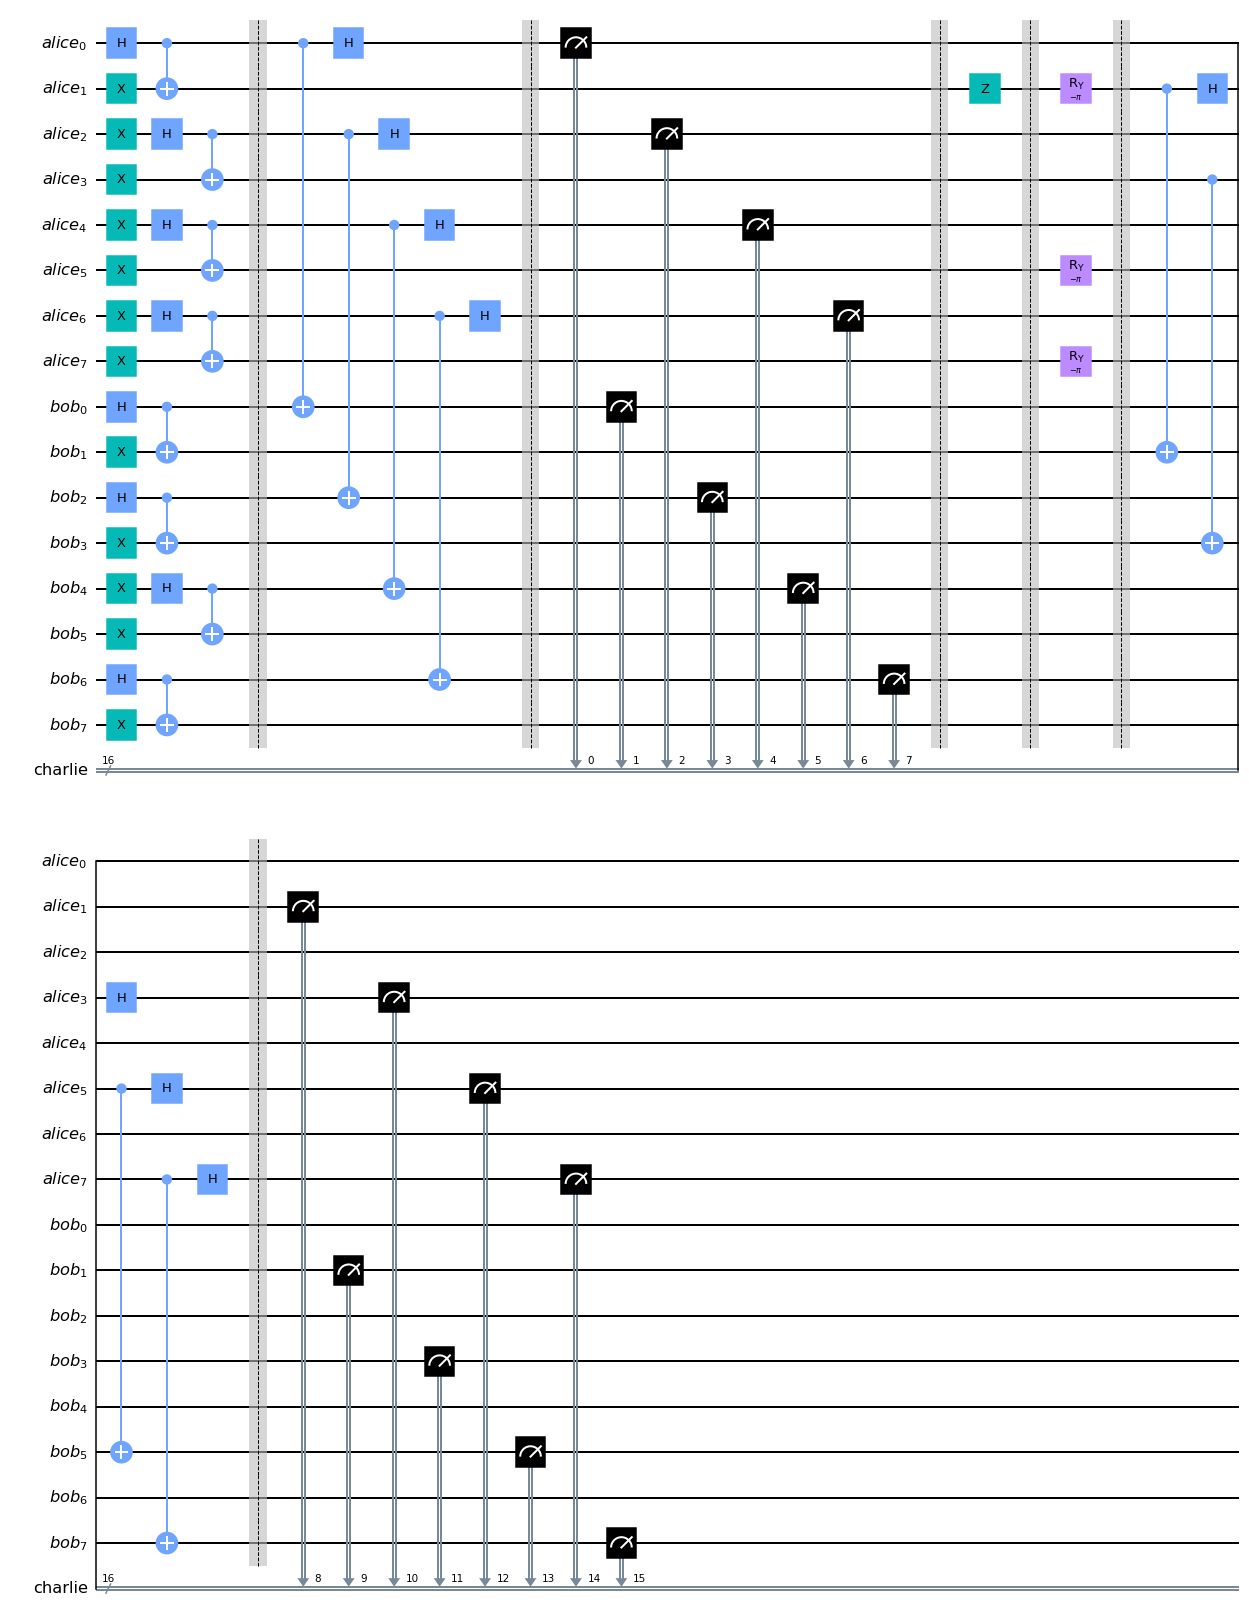

In [11]:
for i in range(1, 2*num_pair, 2):
    circuit.cx(alice_qubits[i], bob_qubits[i])
    circuit.h(alice_qubits[i])

circuit.barrier()
k = 2*num_pair
for i in range(1, 2*num_pair, 2):
    circuit.measure([alice_qubits[i], bob_qubits[i]], [k+i-1,k+i])
circuit.draw(output = 'mpl')

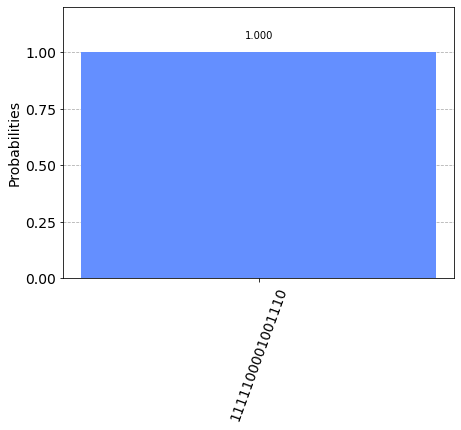

In [12]:
final_count = one_shot_result(circuit)
plot_histogram(final_count)

Here are the final Measurement which will be used by Bob to decode the message 

In [13]:
r = final_count.items()
for res, shots in r:
    result2 = str(res)
print(result2)

1111100001001110


In [14]:
first = result2[2*num_pair:4*num_pair]
second = result2[0:2*num_pair]
first = first[::-1]
second = second[::-1]
print(first)
print(second)

01110010
00011111


Now Our Coding Part Has been done we have to decode the message 
For that we have to consider some assumptions here:
1. Single Qubits has not been introduced yet
2. Sigma_Z operation have not been done yet by BOB

Now to decode the message we look at the following picture
![title](Images/img1.png)

Now Bob knows the Bases of Alice as they are all Psi_Minus 
so Bob just need to compare the
first Result and second result calculate in upper cell
<br>
Now we just need to compare these result with the table given in the 
research paper pdf

In [15]:
#Now bob bases are know as bob_epr
#Here bp is bit flip and pp is phase flip
decoded = []
for i in range(0, 2*num_pair, 2):
    
    bob_base = bob_epr[i//2]
    
    f = first[i:i+2]
    s = second[i:i+2]
    bp = 0
    pp = 0
    
    if f[0] != s[0]:
        bp = 1
    if f[1] != s[1]:
        pp = 1
    if bob_base == 0:
        bp = 1 - bp

    if bp == 0 and pp == 0:
        decoded.append(0)
        decoded.append(0)
    elif bp == 0 and pp == 1:
        decoded.append(0)
        decoded.append(1)
    elif bp == 1 and pp == 0:
        decoded.append(1)
        decoded.append(1)
    else:
        decoded.append(1)
        decoded.append(0)
    
print(str(decoded))
print(message)

[1, 0, 0, 0, 1, 0, 1, 0]
[1 0 0 0 1 0 1 0]


In [16]:
#Comparing the messages
for i in range(len(message)):
    flag = 1
    if int(decoded[i]) != message[i]:
        print("Wrong Output")
        flag = 0
        break
if flag == 1:
    print("The code ran successfully")

The code ran successfully
